In [419]:
import numpy as np
import scipy.io
import networkx as nx
import pandas as pd
from matplotlib import pyplot as plt
import json

from numpy.lib.stride_tricks import sliding_window_view
from opt_einsum import contract
from statsmodels.graphics.tsaplots import plot_acf

### Build Connectome DiGraph

In [420]:
def get_connectome(filepath, sheet_name, existing_connectome=None):
    excel_connectome = pd.read_excel(filepath, sheet_name)
    table = excel_connectome.values[1:,2:]

    neuron_names = set().union(table[1:,0], table[0,1:])
    neuron_names = {x for x in neuron_names if x == x} #remove nans
    neuron_names = sorted(list(neuron_names))

    edge_list = []

    def isnan(x):
        return isinstance(x, float) and np.isnan(x)

    for r in range(1,len(table)):
        for c in range(1,len(table[r])):
            if isnan(table[r][c]) or isnan(table[r][0]) or isnan(table[0][c]):
                continue
            edge_list.append((table[r][0], table[0][c], table[r][c]))

    connectome = existing_connectome if existing_connectome else nx.DiGraph() 
    connectome.add_nodes_from(neuron_names)
    connectome.add_weighted_edges_from(edge_list)
    return connectome

In [421]:
CONNECTOME = get_connectome("datasets/NIHMS1054987-supplement-Supplementary_files/Supplementary Information/SI 5 Connectome adjacency matrices.xlsx", sheet_name="male chemical")

# just take the union of all connectome data
CONNECTOME = get_connectome("datasets/NIHMS1054987-supplement-Supplementary_files/Supplementary Information/SI 5 Connectome adjacency matrices.xlsx", sheet_name="male gap jn symmetric", existing_connectome=CONNECTOME)
CONNECTOME = get_connectome("datasets/NIHMS1054987-supplement-Supplementary_files/Supplementary Information/SI 5 Connectome adjacency matrices.xlsx", sheet_name="male gap jn asymmetric", existing_connectome=CONNECTOME)

In [422]:
print(sorted(((d,n) for n,d in CONNECTOME.degree), reverse=True))

[(138, 'AVAR'), (137, 'hyp'), (132, 'AVAL'), (110, 'AVBR'), (109, 'PVV'), (106, 'EF2'), (104, 'PDB'), (100, 'PVZ'), (96, 'EF3'), (94, 'AVG'), (93, 'PVX'), (91, 'PVNL'), (90, 'AVBL'), (85, 'DVA'), (83, 'EF1'), (83, 'CA05'), (80, 'PVCR'), (78, 'HOB'), (76, 'R7BL'), (74, 'VA12'), (74, 'R1BR'), (71, 'R3BR'), (70, 'DVC'), (70, 'AVFL'), (69, 'PVCL'), (68, 'PVY'), (67, 'PVPL'), (67, 'AVFR'), (66, 'VB09'), (66, 'PQR'), (66, 'CP07'), (66, 'CP04'), (65, 'PVNR'), (65, 'CP05'), (65, 'CA06'), (65, 'AVKR'), (64, 'VB08'), (64, 'R7BR'), (64, 'HOA'), (64, 'CP09'), (64, 'AVKL'), (62, 'VB10'), (62, 'R2BR'), (61, 'PHCL'), (60, 'SPVL'), (60, 'AVDR'), (59, 'SPVR'), (59, 'R2BL'), (59, 'DVF'), (59, 'DD05'), (58, 'DD06'), (57, 'R7AR'), (57, 'R3BL'), (57, 'PHCR'), (57, 'PCAL'), (56, 'RIBR'), (56, 'R9AR'), (55, 'R5BR'), (55, 'PCBL'), (54, 'SMDVL'), (54, 'RIAR'), (54, 'PDC'), (54, 'CP06'), (53, 'SMDDL'), (53, 'RIAL'), (53, 'AVL'), (53, 'AVDL'), (52, 'R7AL'), (52, 'DA08'), (51, 'VA10'), (51, 'SMDDR'), (51, 'PVQR')

In [423]:
fake_connectome = get_connectome('datasets/fake_test_data/fake_connectome.xlsx', 'S1S2N1')

In [424]:
def get_weight(neuron1, neuron2, connectome=CONNECTOME):
    return connectome.get_edge_data(neuron1, neuron2)['weight'] if connectome.get_edge_data(neuron1, neuron2) else 0

In [425]:
class TraceObject:
    def __init__(self, json_filepath):
        with open(json_filepath) as trace_file:
            self.trace_json = json.load(trace_file)
            
        self.num_neurons = self.trace_json['num_neurons']

        self.traces = np.array(self.trace_json['trace_array'])

        self.trace_indices = {}
        for i in range(self.trace_json['num_neurons']):
            if str(i+1) in self.trace_json['labeled']:
                self.trace_indices[self.trace_json['labeled'][str(i+1)]['label']] = i  # neurons are 1-indexed

    def get_label(self, i):
        if str(i+1) not in self.trace_json['labeled']:
            return "" # empty string indicates neuron at index i is unlabeled
        return self.trace_json['labeled'][str(i+1)]['label']
    
    def get_index(self, label):
        if label not in self.trace_indices:
            return -1
        return self.trace_indices[label]
        

In [426]:
def get_relevant_neurons(neuron, connectome=CONNECTOME):
    return set().union([neuron], connectome.successors(neuron), connectome.predecessors(neuron))

def get_relevant_mask(neuron, trace_obj, connectome=CONNECTOME):
    relevant_neurons = get_relevant_neurons(neuron, connectome)
    return np.array([trace_obj.get_label(i) in relevant_neurons for i in range(trace_obj.num_neurons)])

def get_relevant_mask_labels(neuron, trace_obj, connectome=CONNECTOME):
    relevant_neurons = get_relevant_neurons(neuron, connectome)
    indices = []
    for i in range(trace_obj.num_neurons):
        label = trace_obj.get_label(i)
        if label in relevant_neurons:
            indices.append(label)
    return indices

In [427]:
w_rr = 3
w_sr = 1

In [428]:
def calculate_c(neuron, trace_obj, window_start=0, window_width=None, connectome=CONNECTOME):
    if window_width == None:
        window_width = trace_obj.traces.shape[1] - window_start
    num_windows = window_width - max(w_rr,w_sr) + 1

    traces = trace_obj.traces[:,window_start : window_start + window_width]

    
    relevant_mask = get_relevant_mask(neuron, trace_obj, connectome)
    relevant_count = np.count_nonzero(relevant_mask)
    self_index = trace_obj.get_index(neuron)
    if self_index == -1:
        raise ValueError(f"Neuron {neuron} does not have any labeled traces in this dataset.")

    # TODO: We incur a T x relevant_count x w_rr x 1 x (w_sr+1) (about 3000x) blowup here - there is a LOT of redundancy that might be used to bring this down.
    # relevant_count x w_rr x 1 x (w_sr+1) (about 3000) is the number of entries in C
    relevant_sliding_window = np.squeeze(sliding_window_view(traces[relevant_mask,max(w_sr-w_rr,0):], (relevant_count, w_rr), writeable=False), axis=0)
    self_sliding_window = np.squeeze(sliding_window_view(traces[self_index:self_index+1,max(w_rr-w_sr,0):], (1, w_sr), writeable=False), axis=0)
    self_sliding_window = np.concatenate((self_sliding_window, np.ones((num_windows, 1, 1))), axis=2)
    A = contract("tij,tkl->tijkl", relevant_sliding_window, self_sliding_window).reshape(num_windows, relevant_count * w_rr * (w_sr + 1))
    A = A[:-1,:] # can't predict outside of observation window

    # Looking to minimize Ac - traces[neuron]
    observation = traces[self_index][max(w_rr,w_sr):]
    c = np.linalg.inv(A.T @ A) @ A.T @ observation

    plt.plot(np.arange(num_windows-1), observation)
    plt.show()

    plt.plot(np.arange(num_windows-1), A @ c)
    plt.show()

    print(np.linalg.norm(observation - A @ c))

    return c

In [429]:
def live_simulation(c, neuron, trace_obj, start=w_rr, runtime=None, connectome=CONNECTOME):
    trace_len = trace_obj.traces.shape[1]
    if runtime == None or start + runtime > trace_len:
        runtime = trace_len - start

    relevant_mask = get_relevant_mask(neuron, trace_obj, connectome)
    relevant_count = np.count_nonzero(relevant_mask)
    self_index = trace_obj.get_index(neuron)
    temp_traces = np.copy(trace_obj.traces) # we will overwrite the self_index row with our predicted values
    
    C = c.reshape((relevant_count,w_rr,1,w_sr+1))

    for t in range(start,start+runtime):
        relevant_history = temp_traces[relevant_mask,t-w_rr:t]
        self_history = temp_traces[self_index:self_index+1,t-w_sr:t]
        augmented_self_history = np.concatenate((self_history, np.ones((1,1))), axis=1)
        temp_traces[self_index, t] = contract("ij,ijkl,kl", relevant_history, C, augmented_self_history)

    observation = trace_obj.traces[self_index,start:start+runtime]
    plt.plot(np.arange(runtime), observation)
    plt.show()

    prediction = temp_traces[self_index,start:start+runtime]
    plt.plot(np.arange(runtime), prediction)
    plt.show()

    print(np.linalg.norm(observation - prediction))

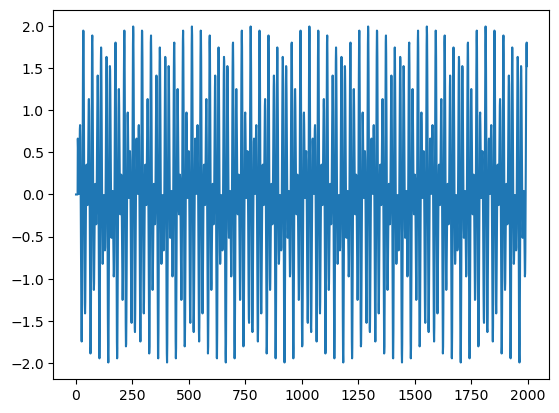

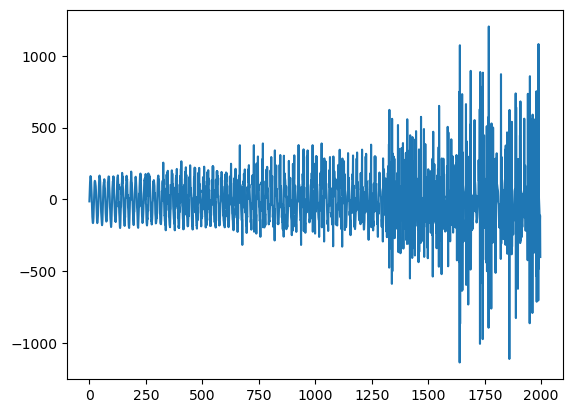

9045.459549682788


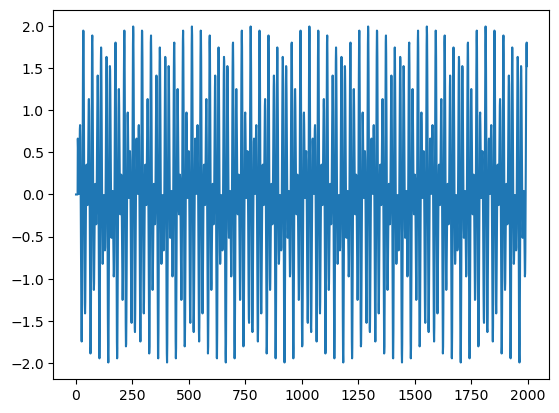

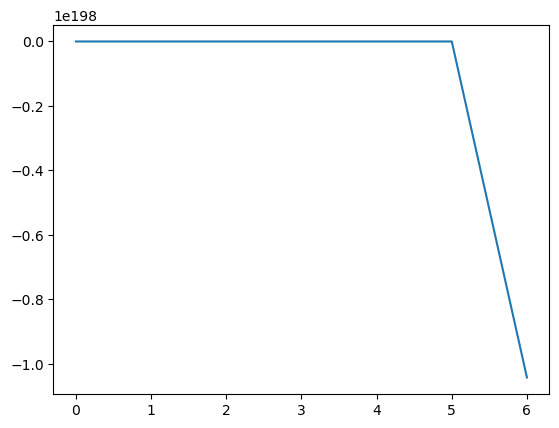

nan


In [430]:
trace_obj = TraceObject('datasets/fake_test_data/fake_traces.json')
c = calculate_c('N1', trace_obj, connectome=fake_connectome)
live_simulation(c, 'N1', trace_obj, connectome=fake_connectome)

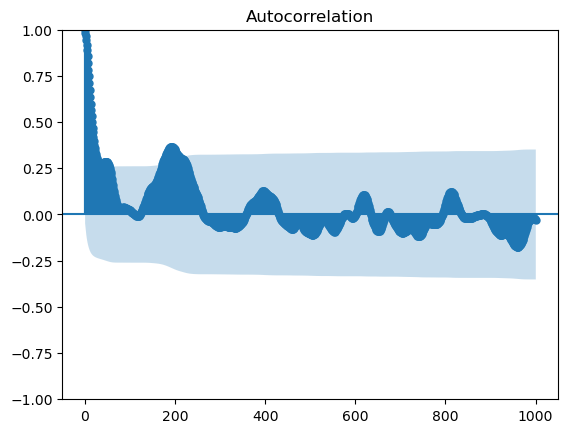

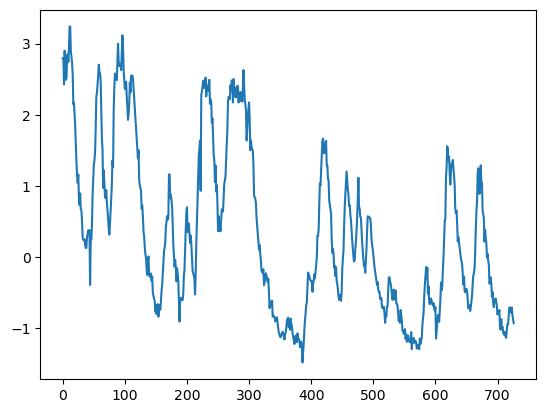

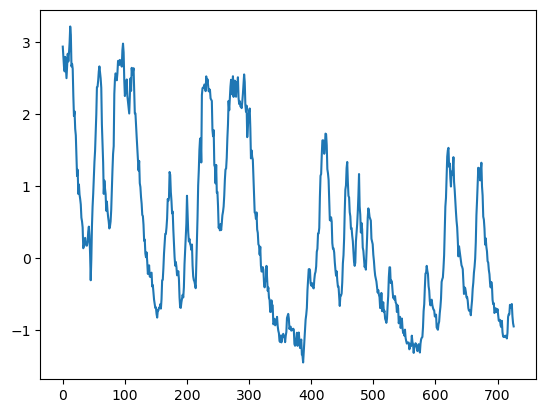

3.673837201290275


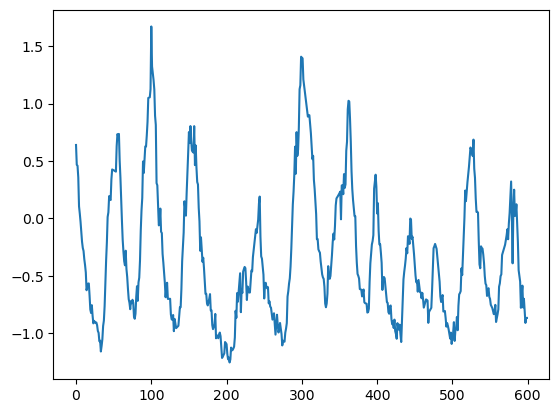

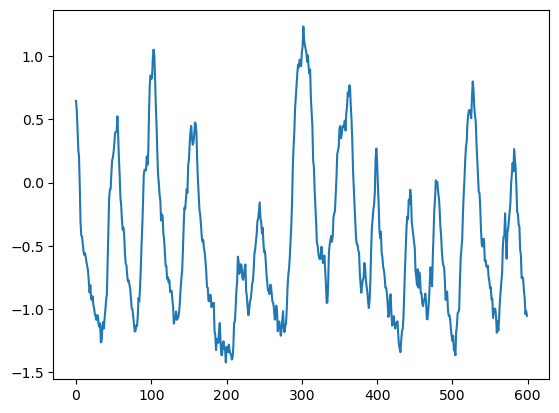

5.671137667953833
102
[-5.40870378e-03 -4.71137680e-03 -4.20145443e-04 -1.02033620e-02
  1.41865173e-02 -2.40324703e-03 -6.59728166e-03 -4.38309215e-04
 -1.68913908e-02 -5.34609862e-03  3.75774436e-03 -3.45586441e-03
 -2.45660048e-02 -5.92539888e-03  1.49403186e-02  1.45855377e-02
  6.34869056e-03 -3.09453809e-02 -1.83897398e-02 -8.51980877e-03
 -4.90075489e-02  1.24529920e-01  9.33758211e-02  5.68135282e-01
  2.50784326e-02 -3.92895531e-02 -1.65480425e-03 -3.57404913e-03
 -6.51126271e-03  7.75405792e-03  7.63779087e-02 -1.56458655e-02
 -3.91999078e-02 -5.26753764e-02 -7.05193363e-02  2.14787598e-01
 -5.04003911e-03  3.08150161e-03 -1.11327283e-02  9.33312879e-03
  3.97503666e-02  2.75318687e-02  2.65607427e-02 -2.35632777e-01
  5.25142329e-02  6.67804490e-02 -1.25853267e-01  3.70638482e-01
  1.80044170e-03  9.74629552e-03 -3.00432491e-03 -9.24485105e-03
  4.68931701e-03  4.34674030e-03  1.01274642e-02 -1.31087448e-02
  7.05413613e-03  6.72524012e-03  3.39160930e-03  7.02381284e-03
  8

In [431]:
neuron = 'AVAR'

trace_obj = TraceObject('datasets/wormwideweb/2022-08-02-01.json')
self_index = trace_obj.get_index(neuron)
if self_index == -1:
    raise ValueError(f"Neuron {neuron} does not have any labeled traces in this dataset.")

plot_acf(trace_obj.traces[self_index,:], lags=1000)
plt.show()

c = calculate_c(neuron, trace_obj, 0, 730)
live_simulation(c, neuron, trace_obj, 1000)

print(len(c))
print(c)

AVAR is at index 3.
['CEPDL', 'AVDR', 'FLPL', 'AVAR', 'FLPR', 'AVER', 'ADEL', 'AVAL', 'RICR', 'URXR', 'RICL', 'URYDR', 'SMDVR', 'SAAVR', 'AVDL', 'CEPVL', 'AVEL']
[0, 33, 0, 0, 0, 8, 0, 108, 0, 0, 0, 8, 1, 0, 39, 0, 0]
[1, 33, 6, 0, 14, 8, 5, 108, 30, 1, 22, 8, 1, 70, 39, 1, 3]


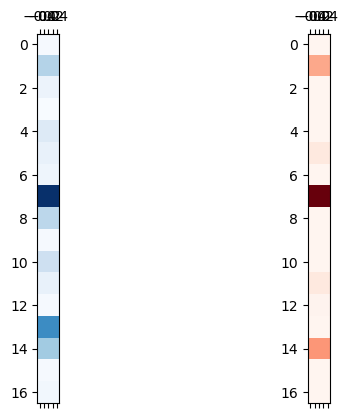

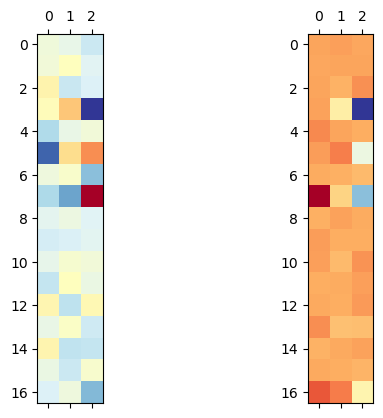

In [432]:
def visualize_c(c, neuron, trace_obj, connectome=CONNECTOME):
    relevant_mask = get_relevant_mask(neuron, trace_obj, connectome)
    relevant_count = np.count_nonzero(relevant_mask)

    self_index_in_relevant_mask = np.count_nonzero(relevant_mask[:trace_obj.get_index(neuron)])
    print(f'{neuron} is at index {self_index_in_relevant_mask}.')
    relevant_labels = get_relevant_mask_labels(neuron, trace_obj, connectome)
    print(relevant_labels)
    print([get_weight(neuron, neighbor) for neighbor in relevant_labels])
    print([get_weight(neighbor, neuron) for neighbor in relevant_labels])


    figure, ax = plt.subplots(1, 2)
    ax[0].matshow(np.array([[get_weight(neighbor, neuron) for neighbor in relevant_labels]]).T, cmap=plt.cm.Blues)
    ax[1].matshow(np.array([[get_weight(neuron, neighbor) for neighbor in relevant_labels]]).T, cmap=plt.cm.Reds)
    figure.show()
    
    C = c.reshape((relevant_count,w_rr,1,w_sr+1))
    figure, ax = plt.subplots(1, w_sr+1) 
    for i in range(w_sr+1):
        (ax if w_sr == 0 else ax[i]).matshow(C[:,:,0,i], cmap=plt.cm.RdYlBu)
    figure.show()

visualize_c(c,neuron, trace_obj)